<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/overlapped_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning a segmentation model on an overlapped speech detection task with `pyannote.audio`

Overlapped speech detection (OSD) is the task of detecting regions where at least two speakers are speaking at the same time. In this notebook, we will finetune a segmentation model on the OSD task, then evaluate an OSD pipeline on AMI database.

## Tutorial setup

### `Google Colab` setup

If you are running this tutorial on `Colab`, execute the following commands in order to setup `Colab` environment. These commands will install `pyannote.audio` and download a mini version of the `AMI` corpus.

In [ ]:
!pip install -qq pyannote.audio==3.1.1
!pip install -qq ipython==7.34.0
!git clone https://github.com/pyannote/AMI-diarization-setup.git
%cd ./AMI-diarization-setup/pyannote/
!bash ./download_ami_mini.sh
%cd /content

⚠ Restart the runtime (Runtime > Restart session).

### Non `Google Colab` setup

If you are not using `Colab`, this tutorial assumes that
* `pyannote.audio` has been installed
* the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/) has already been [setup for use with `pyannote`](https://github.com/pyannote/AMI-diarization-setup/tree/main/pyannote)

## Protocol

Firstly, we define a protocol, here `AMI.SpeakerDiarization.mini`

In [ ]:
from pyannote.database import registry, FileFinder

registry.load_database("AMI-diarization-setup/pyannote/database.yml")
protocol = registry.get_protocol("AMI.SpeakerDiarization.mini", preprocessors={"audio": FileFinder()})

`pyannote.database` *protocols* usually define 
* a training set: `for training_file in protocol.train(): ...`, 
* a validation set: `for validation_file in protocol.development(): ...` 
* an evaluation set `for evaluation_file in protocol.test(): ...`

Let's listen to the first training file and visualize its reference annotation:

In [24]:
first_training_file = next(protocol.train())

In [ ]:
from pyannote.audio.utils.preview import listen
listen(first_training_file)

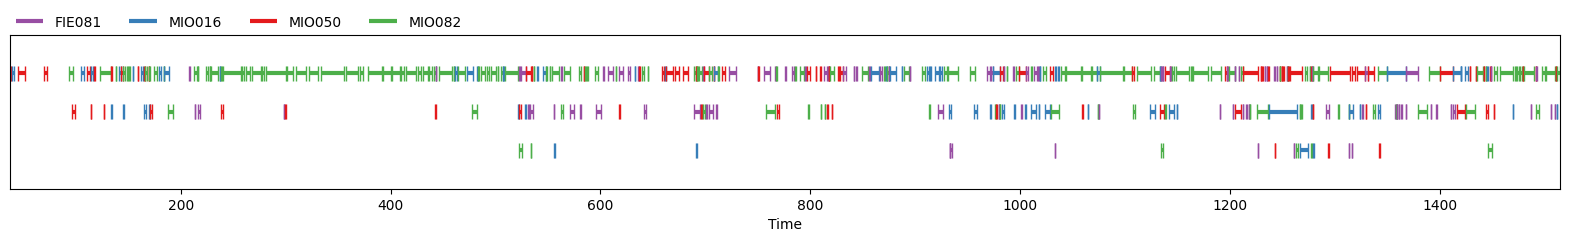

In [26]:
first_training_file['annotation']

The expected output of a perfect overlapped speech detection pipeline would look like this:

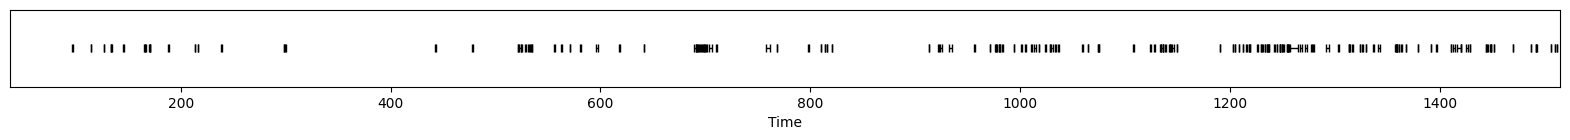

In [27]:
from pyannote.audio.pipelines.overlapped_speech_detection import OracleOverlappedSpeechDetection
oracle_osd = OracleOverlappedSpeechDetection()

oracle_osd(first_training_file).get_timeline()

## Finetuning

In this part, we propose to finetune the [hf.co/pyannote/segmentation-3.0](https://hf.co/pyannote/segmentation-3.0) on an OSD *task*

Firstly, we initialize an OSD *task* that describes how the model will be trained:

* `protocol` indicates that we will use files available in `protocol.train()`.
* `duration=2.` and `batch_size=16` indicates that the model will ingest batches of 16 two seconds long audio chunks.

In [ ]:
from pyannote.audio.tasks import OverlappedSpeechDetection
osd = OverlappedSpeechDetection(protocol, duration=2., batch_size=16)

The next step is to load the segmentation model. Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) models (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters. Despite this initial process, those models can perfectly be downloaded for later offline use: keep reading this tutorial until the end to learn how to do that.

For instance, to load the speaker segmentation model used in this tutorial, you have to visit [hf.co/pyannote/segmentation-3.0](https://hf.co/pyannote/segmentation-3.0), accept the terms, and log in using `notebook_login` below:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

We can then initialize the *pretrained model*: it needs to know about the task (`task=osd`) for which it is being trained for:

In [30]:
from pyannote.audio.core.model import Model

pretrained_model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)
# we assign the OSD task to the model
pretrained_model.task = osd

Now that everything is ready, let's train with `pytorch-ligthning`!

In [33]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=1)
trainer.fit(pretrained_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 1.4 M  | [1, 115, 60]  | [[1, 115, 256], [[8, 1, 128], [8, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?             | ?                                          
3 | classifier        | Linear           | 129    | [1, 115, 128] | [1, 115, 1]                                
4 | activation        | Sigmoid          | 0      | [1, 115, 1]   | [1, 115, 1]                                
5 | validation_metric | MetricCollection | 0      | ?             | ?                                          
-------------------------------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


For the purpose of this tutorial, the model is trained for only 1 epoch. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

## Inference

Once trained, we will apply the model on a test file:

In [34]:
test_file = next(protocol.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".


The expected output is the following:

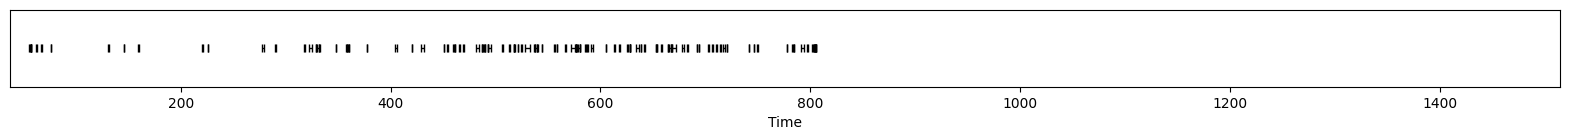

In [35]:
oracle_osd(test_file).get_timeline()

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

In [36]:
from pyannote.audio import Inference
inference = Inference(pretrained_model)
osd_probability = inference(test_file)

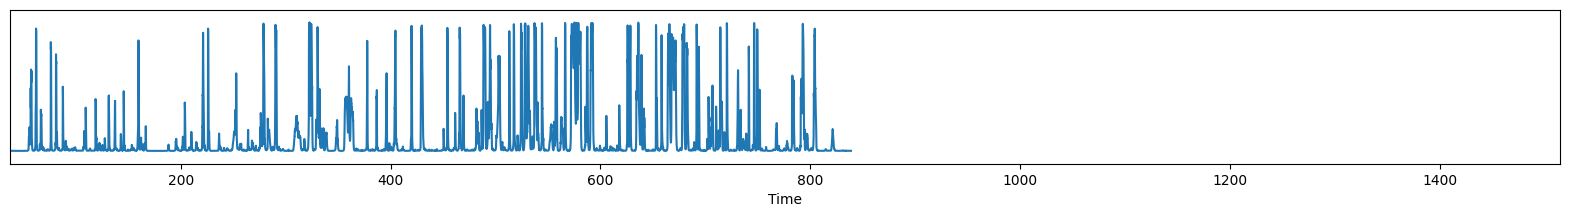

In [37]:
osd_probability

## Pipeline

Almost there! To obtain the final overlapped speech regions, we need to apply a detection threshold.  
For that, we rely on the overlapped speech detection pipeline whose hyper-parameters are set manually:
- `onset=0.5`: mark region as `active` when probability goes above 0.5
- `offset=0.5`: switch back to `inactive` when probability goes below 0.5
- `min_duration_on=0.1`: remove `active` regions shorter than 100ms
- `min_duration_off=0.1`: fill `inactive` regions shorter than 100ms.

In [38]:
from pyannote.audio.pipelines import OverlappedSpeechDetection as OverlappedSpeechDetectionPipeline
pipeline = OverlappedSpeechDetectionPipeline(pretrained_model).instantiate(
    {"onset": 0.5, "offset": 0.5, "min_duration_on": 0.1, "min_duration_off": 0.1})

Here we go:

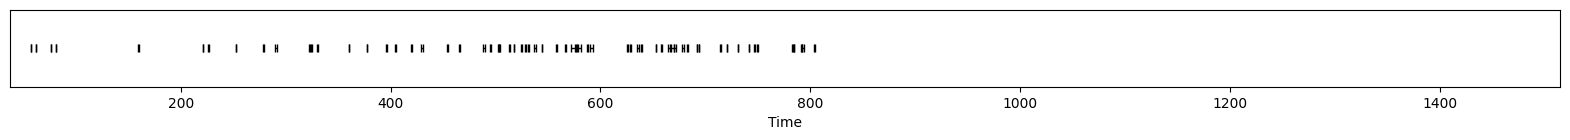

In [39]:
pipeline(test_file).get_timeline()

## Optimizing pipeline hyper-parameters

W can try to optimize the hyper-parameters (that we chose manually above) on the validation set to get better performance.

In [40]:
from pyannote.pipeline import Optimizer
validation_files = list(protocol.development())
optimizer = Optimizer(pipeline)
optimizer.tune(validation_files, n_iterations=200, show_progress=False)

{'loss': 0.7273619100616171,
 'params': {'onset': 0.4321866835452871,
  'offset': 0.33656592926710593,
  'min_duration_on': 0.11171631479481339,
  'min_duration_off': 0.07311754878841395}}

There you go: better hyper-parameters that should lead to better results!

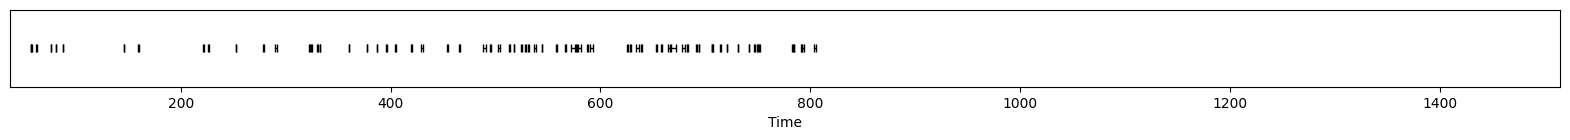

In [41]:
optimized_pipeline = OverlappedSpeechDetectionPipeline(pretrained_model).instantiate(optimizer.best_params)
optimized_pipeline(test_file).get_timeline()